In [26]:
from warnings import filterwarnings
filterwarnings('ignore')

In [27]:
import pandas as pd


In [28]:
df=pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [30]:
m=df.isna().sum()
m[m>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

separate x and y

In [31]:
x=df.drop(columns=['PassengerId','Name','Cabin','Ticket','Survived'])
y=df[['Survived']]

In [32]:
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [33]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


separate cat and con

In [34]:
cat=list(x.columns[x.dtypes=='object'])
con=list(x.columns[x.dtypes!='object'])

In [35]:
cat

['Sex', 'Embarked']

In [36]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

create a feature selection pipeline

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [38]:
num_pipe1=Pipeline(steps=[('impute', SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_pipe1=Pipeline(steps=[('impute',SimpleImputer(strategy='most_frequent')),('ordinal',OrdinalEncoder())])
pre1=ColumnTransformer([('num',num_pipe1,con),('cat',cat_pipe1,cat)]).set_output(transform='pandas')

In [39]:
pre1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Sex', 'Embarked'])])

In [40]:
x_pre=pre1.fit_transform(x)
x_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0


feature selection with mutual info classification

In [41]:
from sklearn.feature_selection import mutual_info_classif
mi=mutual_info_classif(x_pre,y)
mi

array([0.05712616, 0.02473063, 0.        , 0.01285769, 0.13570782,
       0.13256371, 0.00993432])

In [42]:
mi=pd.Series(mi)
mi.index=x_pre.columns
mi=mi.sort_values(ascending=False)
mi

num__Fare        0.135708
cat__Sex         0.132564
num__Pclass      0.057126
num__Age         0.024731
num__Parch       0.012858
cat__Embarked    0.009934
num__SibSp       0.000000
dtype: float64

<Axes: title={'center': 'mutual info score'}>

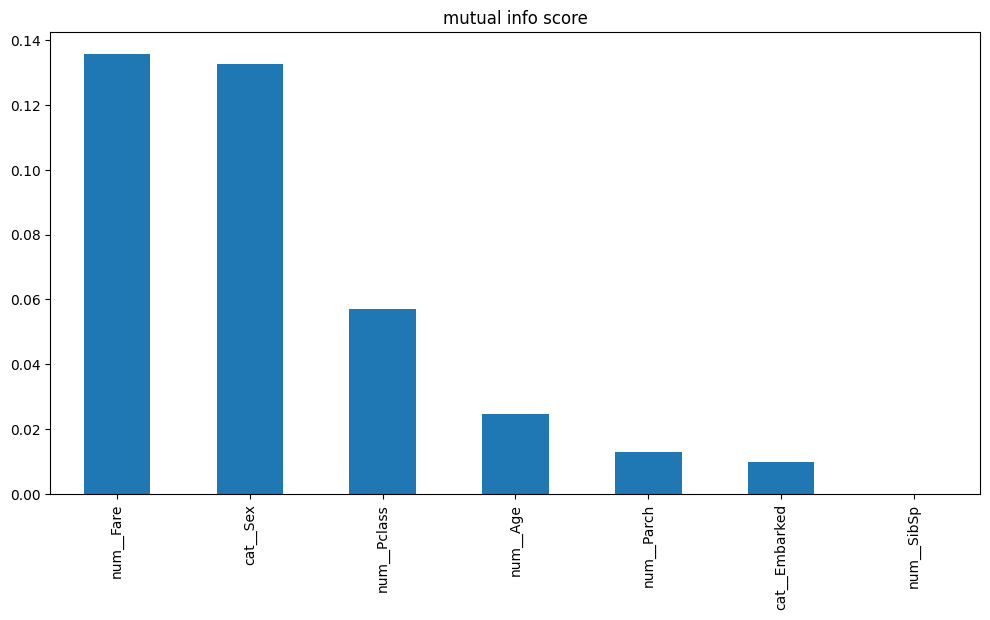

In [43]:
mi.plot(kind='bar',title='mutual info score',figsize=(12,6))

selet top 4 feature as above graph shows

In [44]:
from sklearn.feature_selection import SelectKBest
sel=SelectKBest(mutual_info_classif,k=5)
sel.fit(x_pre,y)


SelectKBest(k=5,
            score_func=<function mutual_info_classif at 0x000001F45163D620>)

In [45]:
sel_cols=sel.get_feature_names_out()
sel_cols

array(['num__Pclass', 'num__SibSp', 'num__Parch', 'num__Fare', 'cat__Sex'],
      dtype=object)

get original column name

In [46]:
sel_cols[0].split('__')[1]

'Pclass'

In [47]:
imp_cols=[]
for i in sel_cols:
    s=i.split('__')[1]
    imp_cols.append(s)

In [48]:
imp_cols

['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex']

In [49]:
x_imp=x[imp_cols]
x_imp

,Pclass,SibSp,Parch,Fare,Sex
0,3,1,0,7.2500,male
1,1,1,0,71.2833,female
2,3,0,0,7.9250,female
3,1,1,0,53.1000,female
4,3,0,0,8.0500,male
...,...,...,...,...,...
886,2,0,0,13.0000,male
887,1,0,0,30.0000,female
888,3,1,2,23.4500,female
889,1,0,0,30.0000,male


separate cat and con for selected column

In [50]:
cat_sel=list(x_imp.columns[x_imp.dtypes=='object'])
con_sel=list(x_imp.columns[x_imp.dtypes!='object'])

In [51]:
cat_sel

['Sex']

In [52]:
con_sel

['Pclass', 'SibSp', 'Parch', 'Fare']

create final preprocessing pipeline

In [53]:
from sklearn.preprocessing import OneHotEncoder

In [55]:
num_pipe2=Pipeline(steps=[('impute',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_pipe2=Pipeline(steps=[('impute',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore',sparse_output=False))])

In [58]:
pre2=ColumnTransformer([('num',num_pipe2,con_sel),('cat',cat_pipe2,cat_sel)]).set_output(transform='pandas')

In [59]:
x_sel_pre=pre2.fit_transform(x_imp)
x_sel_pre

,num__Pclass,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,0.432793,-0.473674,-0.502445,0.0,1.0
1,-1.566107,0.432793,-0.473674,0.786845,1.0,0.0
2,0.827377,-0.474545,-0.473674,-0.488854,1.0,0.0
3,-1.566107,0.432793,-0.473674,0.420730,1.0,0.0
4,0.827377,-0.474545,-0.473674,-0.486337,0.0,1.0
...,...,...,...,...,...,...
886,-0.369365,-0.474545,-0.473674,-0.386671,0.0,1.0
887,-1.566107,-0.474545,-0.473674,-0.044381,1.0,0.0
888,0.827377,0.432793,2.008933,-0.176263,1.0,0.0
889,-1.566107,-0.474545,-0.473674,-0.044381,0.0,1.0


train test split 

In [62]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(x_sel_pre,y,test_size=0.2,random_state=21)

In [63]:
xtrain.shape

(712, 6)

In [64]:
xtest.shape

(179, 6)

create a logistic regression 

In [65]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(xtrain,ytrain)

LogisticRegression()

In [66]:
model.score(xtrain,ytrain)

0.7991573033707865

In [67]:
model.score(xtest,ytest)

0.8044692737430168

predicting result for train and test

In [68]:
ypred_tr=model.predict(xtrain)
ypred_ts=model.predict(xtest)

In [69]:
ypred_tr[0:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [70]:
ytrain.head()

,Survived
793,0
23,1
97,1
9,1
157,0


In [71]:
ypred_ts[0:5]

array([1, 0, 0, 0, 0], dtype=int64)

In [72]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


create a confusion matrix

In [73]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [76]:
c=model.classes_
c

array([0, 1], dtype=int64)

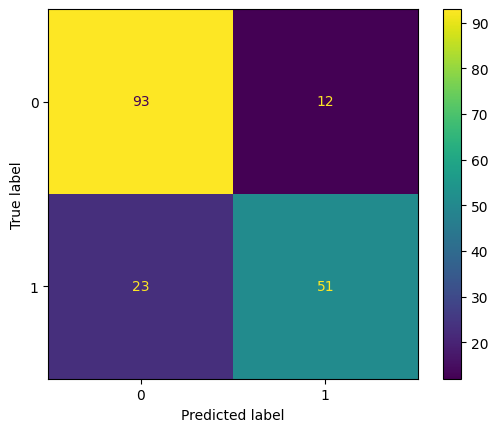

In [78]:
cf=confusion_matrix(ytest,ypred_ts)
cfd=ConfusionMatrixDisplay(cf,display_labels=c)
cfd.plot()

classification report

In [79]:
from sklearn.metrics import classification_report
print(classification_report(ytest,ypred_ts))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



predicting out of sample data

In [80]:
xnew=pd.read_csv('test_titanic.csv')
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [81]:
xnew_pre=pre2.transform(xnew)
xnew_pre

,num__Pclass,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,-0.474545,-0.473674,-0.490783,0.0,1.0
1,0.827377,0.432793,-0.473674,-0.507479,1.0,0.0
2,-0.369365,-0.474545,-0.473674,-0.453367,0.0,1.0
3,0.827377,-0.474545,-0.473674,-0.474005,0.0,1.0
4,0.827377,0.432793,0.767630,-0.401017,1.0,0.0
...,...,...,...,...,...,...
413,0.827377,-0.474545,-0.473674,-0.486337,0.0,1.0
414,-1.566107,-0.474545,-0.473674,1.544246,1.0,0.0
415,0.827377,-0.474545,-0.473674,-0.502445,0.0,1.0
416,0.827377,-0.474545,-0.473674,-0.486337,0.0,1.0


predicting result and probability

In [82]:
preds=model.predict(xnew_pre)
preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [88]:
probs=model.predict_proba(xnew_pre)[:, 1]
probs[0:5]

array([0.1094441 , 0.6051939 , 0.22265647, 0.10962181, 0.57510473])

In [87]:
model.classes_

array([0, 1], dtype=int64)

save to dataframe

In [89]:
df_final=xnew[['PassengerId']]
df_final

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [90]:
df_final['Survived_pred']=preds
df_final['Survived_prob']=probs

In [91]:
df_final

,PassengerId,Survived_pred,Survived_prob
0,892,0,0.109444
1,893,1,0.605194
2,894,0,0.222656
3,895,0,0.109622
4,896,1,0.575105
...,...,...,...
413,1305,0,0.109491
414,1306,1,0.923360
415,1307,0,0.109321
416,1308,0,0.109491


In [92]:
df_final.to_csv('ResultModel_info_classification.csv',index=False)